<a href="https://colab.research.google.com/github/solvedbrunus/Project-3---IronHack/blob/main/newstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Review Analysis and Product Categorization
## Using NLP and LLMs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## 1. Load Data

In [2]:
## 1. Load the data from the CSV file
# Load your dataset
df = pd.read_csv('/content/1429_1.csv')  # Replace with your file path

<ipython-input-2-71e28eda39f6>:3: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/1429_1.csv')  # Replace with your file path


In [3]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Data:\n", df.head())

Dataset Shape: (34660, 21)

Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username']

Missing Values:
 id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       10621
reviews.dateSeen            0
reviews.didPurchase     34659
reviews.doRecommend       594
reviews.id              34659
reviews.numHelpful        529
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title               6
reviews.userCity        34660
reviews.userProvince    3466

# 2. Data Cleaning

In [4]:
def clean_text(text):
    # Convert to string if not already
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing values in 'reviews.text' and 'reviews.rating'
df = df.dropna(subset=['reviews.text', 'reviews.rating'])

# Apply text cleaning
df['cleaned_text'] = df['reviews.text'].apply(clean_text)


In [5]:
# 3. Create Sentiment Labels (based on ratings if available)
def assign_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

if 'reviews.rating' in df.columns:
    df['sentiment'] = df['reviews.rating'].apply(assign_sentiment)

# Check if the sentiment labels are assigned correctly
print(df['sentiment'].value_counts())

sentiment
positive    32315
neutral      1499
negative      812
Name: count, dtype: int64


## 1. Data Preprocessing

In [6]:
def preprocess_text(text):
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Clean and tokenize
    text = text.lower()
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and token.isalnum()]

    return ' '.join(tokens)


In [7]:
# Apply preprocessing to 'cleaned_text'
df['cleaned_text'] = df['cleaned_text'].apply(preprocess_text)

# Display the cleaned text
print(df['cleaned_text'].head())


0    product far disappointed child love use like a...
1    great beginner experienced person bought gift ...
2    inexpensive tablet use learn step nabi thrille...
3    ive fire hd two week love tablet great valuewe...
4    bought grand daughter come visit set user ente...
Name: cleaned_text, dtype: object


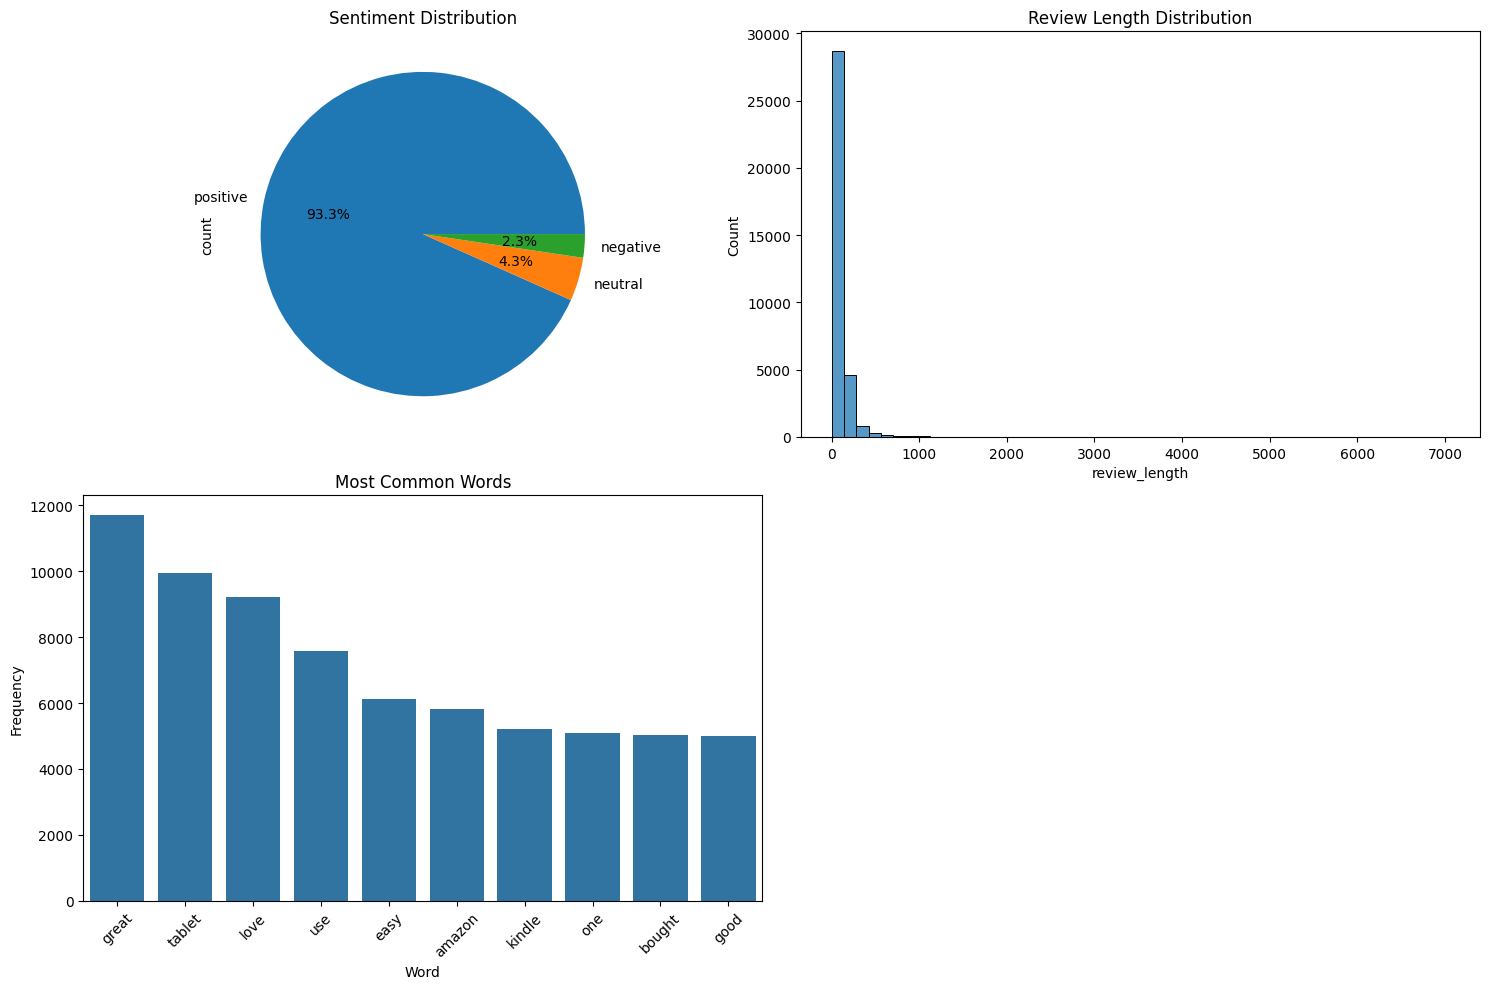


Dataset Summary:
Total reviews: 34626

Sentiment Distribution:
sentiment
positive    93.3
neutral      4.3
negative     2.3
Name: proportion, dtype: float64

Average review length: 96


In [8]:
# 5. Visualizations
plt.figure(figsize=(15, 10))

# Sentiment Distribution Pie Chart
plt.subplot(2, 2, 1)
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution')

# Review Length Distribution
plt.subplot(2, 2, 2)
df['review_length'] = df['cleaned_text'].str.len()
sns.histplot(data=df, x='review_length', bins=50)
plt.title('Review Length Distribution')

# Most Common Words
from collections import Counter
words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(words).most_common(10)
words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])

plt.subplot(2, 2, 3)
sns.barplot(data=words_df, x='Word', y='Frequency')
plt.xticks(rotation=45)
plt.title('Most Common Words')

# Rating Distribution (if available)
if 'rating' in df.columns:
    plt.subplot(2, 2, 4)
    sns.countplot(data=df, x='rating')
    plt.title('Rating Distribution')

plt.tight_layout()
plt.show()

# 6. Save cleaned dataset
df.to_csv('cleaned_reviews.csv', index=False)

# Print summary statistics
print("\nDataset Summary:")
print(f"Total reviews: {len(df)}")
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts(normalize=True).round(3) * 100)
print("\nAverage review length:", int(df['review_length'].mean()))

In [9]:
clean_text = pd.read_csv('cleaned_reviews.csv')

<ipython-input-9-e4fae4acfa1a>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_text = pd.read_csv('cleaned_reviews.csv')


In [10]:
clean_text[['cleaned_text', 'sentiment']].head()

,cleaned_text,sentiment
0,product far disappointed child love use like a...,positive
1,great beginner experienced person bought gift ...,positive
2,inexpensive tablet use learn step nabi thrille...,positive
3,ive fire hd two week love tablet great valuewe...,positive
4,bought grand daughter come visit set user ente...,positive


In [11]:
#balance the dataset 800 reviews each label
#split the data set in to train and test
#apply the pre trained model sentiment-roberta-large-english-3-classes

# Balance the dataset
positive = clean_text[clean_text['sentiment'] == 'positive'].sample(800, random_state=42)
neutral = clean_text[clean_text['sentiment'] == 'neutral'].sample(800, random_state=42)
negative = clean_text[clean_text['sentiment'] == 'negative'].sample(800, random_state=42)

balanced_df = pd.concat([positive, neutral, negative])

## 2. Sentiment Classification using Pre-trained Model

In [12]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split

X = balanced_df['cleaned_text']
y = balanced_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:

# Load the pre-trained sentiment analysis model roBERTa large english 3 classes
classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes", device=0, return_all_scores=True)

# Predict sentiment on the test set
predictions = classifier(X_test.tolist())

# Extract the predicted labels
predicted_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in predictions]

# Evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_labels))

# Save the balanced dataset
balanced_df.to_csv('balanced_reviews.csv', index=False)



Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


              precision    recall  f1-score   support

    negative       0.59      0.51      0.55       157
     neutral       0.38      0.44      0.41       155
    positive       0.68      0.68      0.68       168

    accuracy                           0.55       480
   macro avg       0.55      0.54      0.55       480
weighted avg       0.56      0.55      0.55       480



In [15]:
#save the model
classifier.save_pretrained("sentiment_model")

# Load the saved model
classifier = pipeline("text-classification", model="sentiment_model", return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [35]:
# fine tune the model with the balanced dataset with more epochs

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import pandas as pd
from sklearn.metrics import classification_report

# Load the balanced dataset
balanced_df = pd.read_csv('balanced_reviews.csv')

# Ensure the cleaned_text column contains only strings and handle missing values
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].astype(str).fillna('')

X = balanced_df['cleaned_text']
y = balanced_df['sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create a Dataset object
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))

# Split the dataset into train and test sets
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")
model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Ensure the datasets have the correct format for training
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tune the model
trainer.train()

# Predict sentiment on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = label_encoder.inverse_transform(predictions.predictions.argmax(axis=1))

# Evaluate the fine-tuned model
true_labels = test_dataset['label'].numpy()  # Ensure true labels are in numpy array format


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.898561
2,No log,0.882401
3,0.857300,1.255979
4,0.857300,1.624848
5,0.578000,1.258466
6,0.578000,1.768341
7,0.424000,2.039805
8,0.424000,2.143780
9,0.276000,2.267442
10,0.276000,2.235001


In [36]:
print(classification_report(label_encoder.inverse_transform(true_labels), predicted_labels))

              precision    recall  f1-score   support

    negative       0.72      0.63      0.67       163
     neutral       0.55      0.59      0.57       169
    positive       0.67      0.72      0.69       148

    accuracy                           0.64       480
   macro avg       0.65      0.64      0.64       480
weighted avg       0.64      0.64      0.64       480



## 3. Category Clustering - group similar reviews - type of product

In [40]:
import pandas as pd

# Load the balanced dataset
balanced_df = pd.read_csv('balanced_reviews.csv')

# Ensure the cleaned_text column contains only strings and handle missing values
balanced_df['cleaned_text'] = balanced_df['cleaned_text'].astype(str).fillna('')
X = balanced_df['cleaned_text']

In [38]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [41]:
from bertopic import BERTopic

# Create a BERTopic model
topic_model = BERTopic(language="english")

# Fit the model on the review data
topics, probabilities = topic_model.fit_transform(X)

# Extract topics and their representative terms
topic_info = topic_model.get_topic_info()
representative_terms = {topic: topic_model.get_topic(topic) for topic in topic_info.Topic.unique()}

# Display the topics and their representative terms
print(topic_info)
for topic, terms in representative_terms.items():
    print(f"Topic {topic}: {terms}")

   Topic  Count                         Name  \
0      0   2059   0_tablet_amazon_great_good   
1      1    341  1_alexa_echo_music_question   

                                      Representation  \
0  [tablet, amazon, great, good, kindle, use, one...   
1  [alexa, echo, music, question, answer, home, s...   

                                 Representative_Docs  
0  [said complain purchased could something inexp...  
1  [work great love play music answer question, a...  
Topic 0: [('tablet', 0.07515852717750234), ('amazon', 0.051423939100916534), ('great', 0.04375881230140205), ('good', 0.04239066420125116), ('kindle', 0.04045529586966682), ('use', 0.039861517095041966), ('one', 0.03800040954910746), ('bought', 0.03769831830904261), ('work', 0.036730156207486125), ('fire', 0.03600827365186927)]
Topic 1: [('alexa', 0.11195380932578579), ('echo', 0.09594838452801348), ('music', 0.09201788150140981), ('question', 0.0696872357137098), ('answer', 0.05241667014851222), ('home', 0.05172237

Coherence Score: 0.5800252130672383
Silhouette Score: 0.5596588324404695


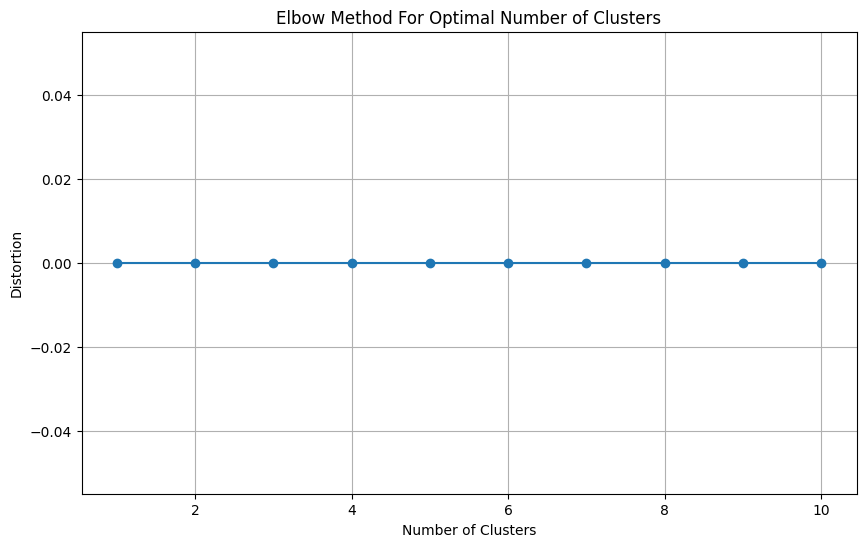

In [57]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate coherence score
def calculate_coherence_score(model, texts):
    from gensim.models.coherencemodel import CoherenceModel
    from gensim.corpora.dictionary import Dictionary
    topics = model.get_topics()
    # Convert topics to the required format
    formatted_topics = [[word for word, _ in topic] for topic in topics.values()]
    # Create a Gensim dictionary from the texts
    dictionary = Dictionary([text.split() for text in texts])
    coherence_model = CoherenceModel(topics=formatted_topics, texts=[text.split() for text in texts], dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()


# Function to calculate silhouette score
def calculate_silhouette_score(model, embeddings):
    # Get the topics directly from the model's fit_transform result
    labels = model.topics_
    # Reshape embeddings to be 2D
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(-1, 1)
    return silhouette_score(embeddings, labels)

# Function to calculate elbow method score
def calculate_elbow_method(model, docs, embeddings, max_clusters=10):
    distortions = []
    for k in range(1, max_clusters + 1):
        # Reduce topics with original documents
        reduced_model = model.reduce_topics(docs, nr_topics=k)
        # Calculate distortion using the reduced model
        topics, _ = reduced_model.transform(docs)
        distortions.append(np.sum(np.square(topics)))
    return distortions



# Calculate coherence score
coherence_score = calculate_coherence_score(topic_model, X)
print(f"Coherence Score: {coherence_score}")

# Calculate silhouette score
silhouette_score_value = calculate_silhouette_score(topic_model, probabilities)
print(f"Silhouette Score: {silhouette_score_value}")

# Calculate elbow method score
elbow_scores = calculate_elbow_method(topic_model, X, probabilities)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(elbow_scores) + 1), elbow_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.grid(True)
plt.show()

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [61]:
# Calculate silhouette score for the best model
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(probabilities)
silhouette_score_value = calculate_silhouette_score(best_model, embeddings_2d)
print(f"Silhouette Score: {silhouette_score_value}")

ValueError: Expected 2D array, got 1D array instead:
array=[0.94093367 0.63850999 0.60102614 ... 0.         1.         1.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

from transformers import AutoTokenizer, AutoModel
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('siebert/sentiment-roberta-large-english')
model = AutoModel.from_pretrained('siebert/sentiment-roberta-large-english')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Apply the function to get embeddings for each text
embeddings = np.vstack(df['cleaned_text'].apply(get_embeddings))

In [ ]:

# use BerTopic

#check if i have the right number of cluster - do a parameter search


#for each cluster find the words that show up more often

for i in range(n_clusters):
    cluster_texts = df[df['cluster'] == i]['cleaned_text'].tolist()
    print(f"Cluster {i} sample texts:", cluster_texts[:5])  # Print sample texts from each cluster

## 4. Summarize - prompt enge

In [ ]:
#qwen



Your max_length is set to 50, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)



Cluster 0 Summary:
 tablet meet basic need price price great basic function tablet hardcore user may want ipad flexibility kindle bigger screen like surf web download read book. easy elderly user cease ad pop got present love size screen purchased last tablet died.

Cluster 1 Summary:
 really like tablet would given star sometimes push start several time unlock screen little annoying surprised learned capability device husband access desktop thing couldnt device really hoping would faster inexspensive tablet ive mainly use email though job bought christmas gift someone bought

Cluster 2 Summary:
This screen really nice look nice crisp bright infact brighter ipad pro costing base model build fire insanely awesome running mm thick smooth glossy feel back really amazing hold like futuristic tab ur hand bought grand daughter come visit set user entered age name am

Cluster 3 Summary:
 product far disappointed child love use like ability monitor control content see ease bought tablet famil

## 5. Analysis Results

# Display overall statistics
print("Sentiment Distribution:")
print(df['sentiment'].value_counts())

print("\nCluster Sizes:")
print(df['cluster'].value_counts())

# Save results
df.to_csv('analysis_results.csv', index=False)